In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters as fl
from skimage.color import rgb2gray
from skimage import io
from skimage.transform import rescale
from skimage.filters import threshold_otsu, sobel
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.morphology import watershed
from skimage.color import label2rgb
from skimage.feature import canny
from scipy import ndimage as ndi
import glob

In [2]:
def plot_image(img, title='Image'):
    plt.figure(figsize=[5,5])
    plt.imshow(img, cmap='gray')
    plt.title(title)
#     plt.axis('off')

In [3]:
def nms_fast(boxes, probs=None, overlapThresh=0.3):
    
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

In [4]:
def nms_og(boxes, overlapThresh=0.5):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]

        # loop over all indexes in the indexes list
        for pos in range(0, last):
            # grab the current index
            j = idxs[pos]

            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]

            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)

        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)

    # return only the bounding boxes that were picked
    return boxes[pick]

In [28]:
def bbox(image):
    image = image[:-35,...]
    threshs = [7,17,27,37,47,57]
    boxes = []
    for thresh in threshs:
        img = np.zeros_like(image)
        blur = cv2.medianBlur(image, thresh)
        # blur = image
        gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
        thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,3)

        canny = cv2.Canny(thresh, 120, 255, 1)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
        opening = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, kernel)
        dilate = cv2.dilate(opening, kernel, iterations=2)

        cnts = cv2.findContours(dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]

        min_area = 3000
        for c in cnts:
            area = cv2.contourArea(c)
            if area > min_area:
                cv2.drawContours(img, [c], -1, (36, 255, 12), 2)
        img = rgb2gray(img)
        x,y = np.nonzero(img)
        #print(x)
        if len(x):
            xm = x.min()
            xma = x.max()

            x, y = np.nonzero(img[xm+15:xma-15,:])
            ym = y.min()
            yma = y.max()

            boxes += [[xm,ym,xma,yma]]
        
    return np.array(boxes)

In [29]:
image = cv2.imread('../data/201305009_LIMI_002851.jpg')
image = (255*rescale(image,0.25)).astype(np.uint8)

/home/a_parida/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


In [30]:
boxes = bbox(image)

In [31]:
box = nms_og(boxes)

In [32]:
box

array([[145,   0, 309, 461]])

In [33]:
b1 = box[-1]
# b2 = box[1]

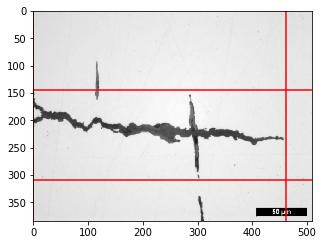

In [34]:
plt.figure(figsize=[5,5])
plt.imshow(image, cmap='gray')
plt.axvline(b1[1],color='r')
plt.axvline(b1[-1], color='r')
plt.axhline(b1[0],color='r')
plt.axhline(b1[2], color='r')
# plt.axvline(b2[1],color='g')
# plt.axvline(b2[-1], color='g')
# plt.axhline(b2[0],color='g')
# plt.axhline(b2[2], color='g')
# plt.axis('off')
plt.show()

# 